In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from fringes import fringe_wrapper
from config import config
from phase import phase_wrapper, PE

rmse = lambda diff: np.sqrt(np.nanmean(diff ** 2))
dist = lambda points: np.sqrt(np.sum(points**2, axis=-1))

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
end_header
'''
def write_ply(fn, verts):
    verts = verts[:,20:-20,:]
    verts = verts.reshape(-1, 3)
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f')
        
def recons3d(disparity):
    h, w = disparity.shape[0:2]
    f = 5.0*w                          # artificial focal length                      
    Q = np.float32([[5, 0, 0, -0.5*w],
                    [0,-5, 0,  0.5*h], # turn points 180 deg around x-axis,
                    [0, 0, 0,     -f], # so that y-axis looks up
                    [0, 0, 1,      0]])
    points = cv2.reprojectImageTo3D(disparity.astype(np.float32), Q)
    return points

methods = ["PE", "MPE", "LLS", "CFPE"]
colors = ['c','g','b','r','black','yellow']
linetypes = [":>", "--s", "-.<", "-o","-o"]

In [8]:
# config
cfg = config()
cfg.debug = False
cfg.pattern_size = [1920, 1080]
cfg.camera_size = [1920,1080]
cfg.Tp = [170, 190]       #在这个实验中，就先设置成这个周期。

# Note that, we must update Tc and alpha for correct phase extraction
cfg.Tc = cfg.Tp # Tc is for camera recordings

In [9]:
cfg.A = [128,128]
cfg.B = [100,100]
cfg.C, cfg.D, cfg.E , cfg.F= 5,4,3,2

def Triple_N_step(cfg, noise_model):
    # generate the test images, ground truth of phase map and points
    fringe_generator = fringe_wrapper(cfg, noise_model)
    fringe_images = fringe_generator.generate_all()
    phase_truth = fringe_generator.generate_phase()
    point_truth = recons3d(phase_truth*0+88)
    
    # phase extraction and convert to 3d points
    phase_measures = PE(cfg).psi_extract(images=fringe_images[0])              # 用9-step求包裹相位
    phase_measures_unwrapped,T = PE(cfg).basic_extract2(images=fringe_images)  # 用9-step相位展开

    disparitys = (phase_measures_unwrapped - phase_truth) * cfg.Tp[0] / (2 * np.pi) + 88
    # #print(disparitys)
    point_measures = recons3d(disparitys)

    # Performance evaluation
    # rmse_phase = rmse(phase_measures[:, 20:-20] - phase_truth[:, 20:-20])
    rmse_point = rmse(dist(point_measures[:,75:125,:] - point_truth[:,75:125,:]))

    return phase_truth, point_truth, phase_measures,phase_measures_unwrapped, fringe_images, rmse_point


cfg.gamma=1.3
noise_model = "gamma"
cfg.steps = [9,9]
phase_truth1, point_truth1, phase_measures1, phase_measures1_unwrapped, new_triple_N_fringe, rmse1_point = Triple_N_step(cfg,noise_model)
cfg.steps = [12,12]
phase_truth2, point_truth2, phase_measures2, phase_measures2_unwrapped, old_triple_N_fringe, rmse2_point = Triple_N_step(cfg,noise_model)


In [10]:
def old_Triple_N_step(i,cfg,fringe_image):
    img1_group0 = []
    img1_group1 = []
    img1_group2 = []
    if i == 1:
        name = 0
    if i == 2:
        name = 1
    print(name)
    img1_0, img1_3, img1_6 = fringe_image[name][11], fringe_image[name][3], fringe_image[name][7]
    img1_group0.append(img1_0)
    img1_group0.append(img1_3)
    img1_group0.append(img1_6)
    img1_1, img1_4, img1_7 = fringe_image[name][0], fringe_image[name][4], fringe_image[name][8]
    img1_group1.append(img1_1)
    img1_group1.append(img1_4)
    img1_group1.append(img1_7)
    img1_2, img1_5, img1_8 = fringe_image[name][1], fringe_image[name][5], fringe_image[name][9]
    img1_group2.append(img1_2)
    img1_group2.append(img1_5)
    img1_group2.append(img1_8)

    phase_measures0 = PE(cfg).psi_extract(images=img1_group0)  # 用origin求包裹相位
    phase_measures1 = PE(cfg).psi_extract(images=img1_group1)  # 用2pai/3N求包裹相位
    phase_measures2 = PE(cfg).psi_extract(images=img1_group2)  # 用4pai/3N求包裹相位

    return phase_measures0,phase_measures1,phase_measures2

def new_Triple_N_step(i,cfg,fringe_image):
    img1_group0 = []
    img1_group1 = []
    img1_group2 = []
    if i == 1:
        name = 0
    if i == 2:
        name = 1
    print(name)
    img1_0, img1_3, img1_6 = fringe_image[name][8], fringe_image[name][2], fringe_image[name][5]
    img1_group0.append(img1_0)
    img1_group0.append(img1_3)
    img1_group0.append(img1_6)
    img1_1, img1_4, img1_7 = fringe_image[name][0], fringe_image[name][3], fringe_image[name][6]
    img1_group1.append(img1_1)
    img1_group1.append(img1_4)
    img1_group1.append(img1_7)
    img1_2, img1_5, img1_8 = fringe_image[name][1], fringe_image[name][4], fringe_image[name][7]
    img1_group2.append(img1_2)
    img1_group2.append(img1_5)
    img1_group2.append(img1_8)

    phase_measures0 = PE(cfg).psi_extract(images=img1_group0)  # 用origin求包裹相位
    phase_measures1 = PE(cfg).psi_extract(images=img1_group1)  # 用2pai/3N求包裹相位
    phase_measures2 = PE(cfg).psi_extract(images=img1_group2)  # 用4pai/3N求包裹相位

    return phase_measures0,phase_measures1,phase_measures2


def unwrapped_phase(cfg, psi):
    phi1, T1 = PE(cfg).phase_unwarping2(psi[0],psi[1],cfg.Tc[0],cfg.Tc[1])
    phi1 = phi1*T1/cfg.Tc[0]
    phi1 = phi1.astype(np.float32)
    return phi1,T1

def phase_to_point(cfg,phase_measures,phase_truth,point_truth):
    disparitys = (phase_measures - phase_truth) * cfg.Tp[0] / (2 * np.pi) + 88
    #print(disparitys)
    point_measures = recons3d(disparitys)
    rmse_point = rmse(dist(point_measures[:,75:125,:] - point_truth[:,75:125,:]))
    return rmse_point

cfg.steps = [3,3]
old_psi = []
phase_measures3,phase_measures4,phase_measures5 = old_Triple_N_step(1, cfg, old_triple_N_fringe)    # 低频下的
phase_measures33,phase_measures44,phase_measures55 = old_Triple_N_step(2, cfg, old_triple_N_fringe)    # 低频下的
old_psi.append((phase_measures3 + phase_measures4 + phase_measures5)/3)
old_psi.append((phase_measures33 + phase_measures44 + phase_measures55)/3)
old_Triple_N_step_unwrapped_phase, old_Triple_N_step_T= unwrapped_phase(cfg, old_psi)
old_Triple_N_step_point_rmse = phase_to_point(cfg, old_Triple_N_step_unwrapped_phase, phase_truth1, point_truth1)

new_psi = []
phase_measures6,phase_measures7,phase_measures8 = new_Triple_N_step(1, cfg, new_triple_N_fringe)    # 低频下的
phase_measures66,phase_measures77,phase_measures88 = new_Triple_N_step(2, cfg, new_triple_N_fringe)    # 低频下的
new_psi.append((phase_measures6 + phase_measures7 + phase_measures8)/3)
new_psi.append((phase_measures66 + phase_measures77 + phase_measures88)/3)
new_Triple_N_step_unwrapped_phase, new_Triple_N_step_T = unwrapped_phase(cfg, new_psi)
new_Triple_N_step_point_rmse = phase_to_point(cfg, new_Triple_N_step_unwrapped_phase, phase_truth1, point_truth1)


three_psi = []
three_psi.append(phase_measures7)
three_psi.append(phase_measures77)
three_step_unwrapped_phase, three_step_T = unwrapped_phase(cfg, three_psi)
three_step_point_rmse = phase_to_point(cfg, three_step_unwrapped_phase, phase_truth1, point_truth1)

0
1
0
1


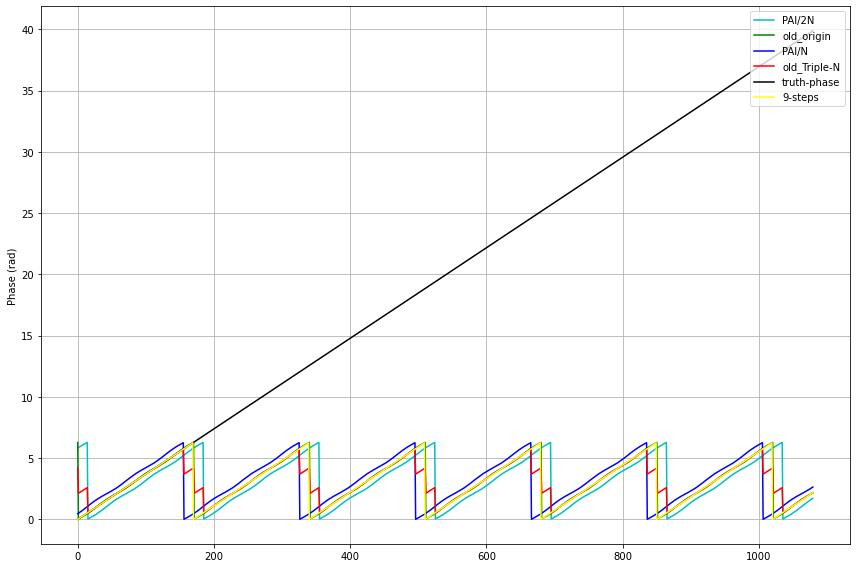

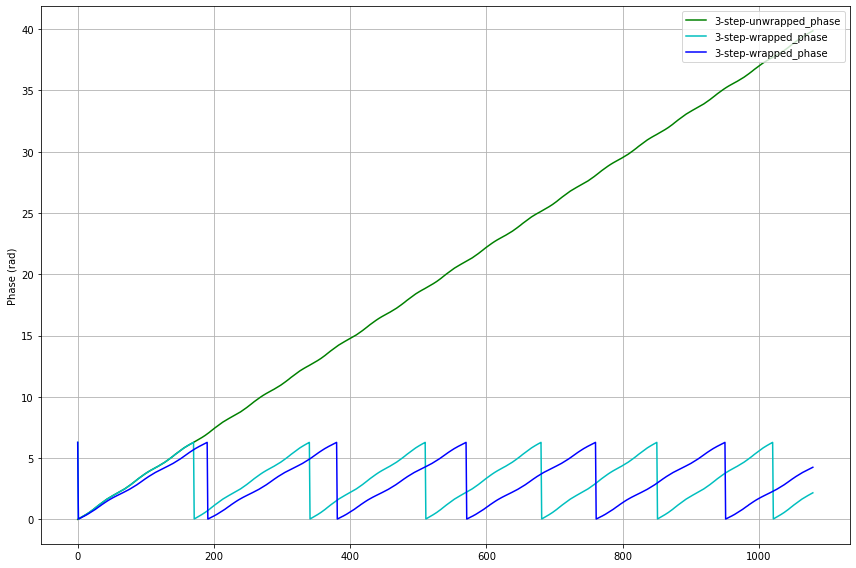

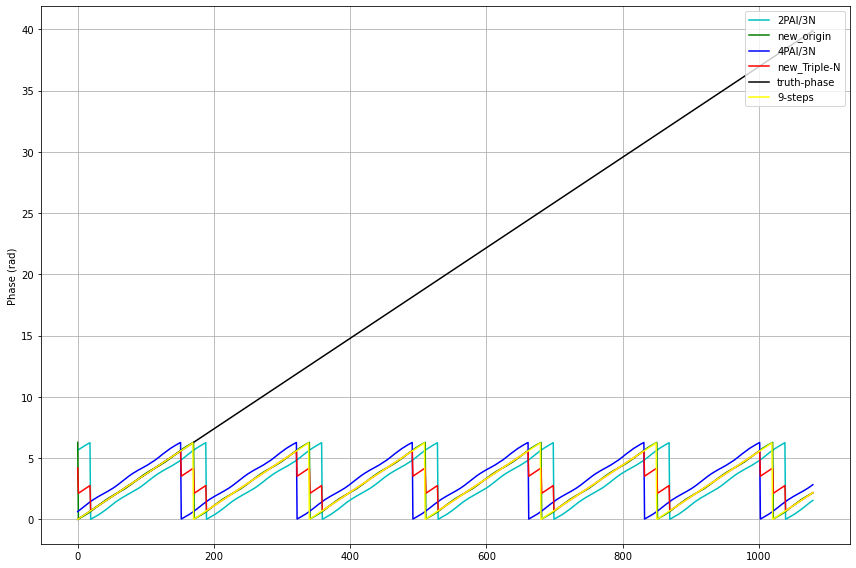

In [11]:
# 精度问题
# 
plt.figure(figsize=(12, 8))
line = 50
plt.plot(phase_measures3[line,:1080],color=colors[0], label="PAI/2N")
plt.plot(phase_measures4[line,:1080],color=colors[1],label="old_origin")
plt.plot(phase_measures5[line,:1080],color=colors[2],label="PAI/N")
plt.plot((phase_measures3[line,:1080]+phase_measures4[line,:1080]+phase_measures5[line,:1080])/3,color=colors[3],label="old_Triple-N")
plt.plot(phase_truth1[line,:1080],color=colors[4],label="truth-phase")
plt.plot(phase_measures1[line,:1080],color=colors[5],label="9-steps")
plt.ylabel("Phase (rad)")
plt.legend(loc=1)
plt.grid("on")
plt.tight_layout()
# plt.ylim(0,10)

# 相位展开的效果
plt.figure(figsize=(12, 8))
line = 50
# plt.plot(phase_measures1_unwrapped[line,:1080],color=colors[0], label="9-step-unwrapped_phase")
plt.plot(three_step_unwrapped_phase[line,:1080],color=colors[1], label="3-step-unwrapped_phase")
plt.plot(phase_measures7[line,:1080],color=colors[0], label="3-step-wrapped_phase")
plt.plot(phase_measures77[line,:1080],color=colors[2], label="3-step-wrapped_phase")
# plt.plot(old_Triple_N_step_unwrapped_phase[line,:1080],color=colors[2],label="old_Triple_N_step_unwrapped_phase")
# plt.plot(new_Triple_N_step_unwrapped_phase[line,:1080],color=colors[3],label="new_Triple_N_step_unwrapped_phase")
# plt.plot(phase_truth1[line,:1080],color=colors[4],label="truth-phase")
plt.ylabel("Phase (rad)")
plt.legend(loc=1)
plt.grid("on")
plt.tight_layout()
# plt.ylim(0,10)


plt.show()
plt.figure(figsize=(12, 8))
plt.plot(phase_measures6[line,:1080],color=colors[0], label="2PAI/3N")
plt.plot(phase_measures7[line,:1080],color=colors[1],label="new_origin")
plt.plot(phase_measures8[line,:1080],color=colors[2],label="4PAI/3N")
plt.plot((phase_measures6[line,:1080]+phase_measures7[line,:1080]+phase_measures8[line,:1080])/3,color=colors[3],label="new_Triple-N")
plt.plot(phase_truth1[line,:1080],color=colors[4],label="truth-phase")
plt.plot(phase_measures1[line,:1080],color=colors[5],label="9-steps")
# plt.plot(phase3_unwrapped[line,:], linetypes[2],color=colors[2],label="phase-truth")
plt.ylabel("Phase (rad)")
plt.legend(loc=1)
plt.grid("on")
plt.tight_layout()
# plt.ylim(0,10)
plt.show()

In [12]:
old_wrapped_rmse = rmse((phase_measures3[:,75:125]+phase_measures4[:,75:125]+phase_measures5[:,75:125])/3 - phase_truth1[:, 75:125])
new_wrapped_rmse = rmse((phase_measures6[:,75:125]+phase_measures7[:,75:125]+phase_measures8[:,75:125])/3 - phase_truth1[:, 75:125])
nine_step_wrapped_rmse = rmse(phase_measures1[:,75:125]-phase_truth1[:, 75:125])
three_step_wrapped_rmse = rmse(phase_measures4[:,75:125]-phase_truth1[:, 75:125])
old_unwrapped_rmse = rmse(old_Triple_N_step_unwrapped_phase[:,75:125] - phase_truth1[:, 75:125])
new_unwrapped_rmse = rmse(new_Triple_N_step_unwrapped_phase[:,75:125] - phase_truth1[:, 75:125])
nine_step_unwrapped_rmse = rmse(phase_measures1_unwrapped[:,75:125]-phase_truth1[:, 75:125])
three_step_unwrapped_rmse = rmse(three_step_unwrapped_phase[:,75:125]-phase_truth1[:, 75:125])

print("                       old_Triple-N            new_Triple_N            9-step            3-step")
print("rmse(wrapped_phase)    {}     {}      {}      {} ".format(old_wrapped_rmse,new_wrapped_rmse,nine_step_wrapped_rmse,three_step_wrapped_rmse))
print("rmse(unwrapped_phase)  {}    {}      {}      {} ".format(old_unwrapped_rmse,new_unwrapped_rmse,nine_step_unwrapped_rmse,three_step_unwrapped_rmse))
print("rmse(point_rmse)       {}        {}       {}       {} ".format(old_Triple_N_step_point_rmse,new_Triple_N_step_point_rmse,rmse1_point,three_step_point_rmse))
# print("rmse error: ",error)

                       old_Triple-N            new_Triple_N            9-step            3-step
rmse(wrapped_phase)    0.013875812481363242     0.001397838744476392      0.0013740013412054922      0.04083513398324171 
rmse(unwrapped_phase)  0.013875816721561225    0.0013978461930796212      0.0013740087802338473      0.04083513723783238 
rmse(point_rmse)       0.4824478328227997        0.04871245473623276       0.04788022115826607       1.415549635887146 
